## Active Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sbi
sbi.__version__

'0.18.0'

In [3]:
import torch
from torch import ones, zeros, eye

from sbi.inference import SNLE, SNPE
from sbi.utils import BoxUniform
from sbi.utils.torchutils import atleast_2d
from sbi.analysis import pairplot
from sbi.inference import MCMCPosterior, RejectionPosterior
from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

import matplotlib.pyplot as plt

from loss_calibration.loss import StepLoss_weighted, SigmoidLoss_weighted

Prior and Simulator

In [4]:
prior = BoxUniform(-ones(2), ones(2))
def sim(theta):
    return theta + torch.randn(theta.shape) * 0.2

Define a potential

In [5]:
class AcquisitionPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, device="cpu"):
        super().__init__(prior, x_o, device=device)
    
    def __call__(self, theta, track_gradients=True):
        return acquisition_fn(theta)


Define a cost function and an acquisition function

In [6]:
#cost_fn = StepLoss_weighted([2,1], 0.)    # ! torch.gt breaks backward pass of gradients
cost_fn = SigmoidLoss_weighted([2,1], 0.)

In [8]:
num_monte_carlo_samples_likelihood = 10
num_monte_carlo_samples_posterior = 1

In [9]:
# cost/acquisition fun without batches

# def cost_fn(true_theta, sampled_theta):
#     costs = []
#     for s in sampled_theta:
#         if true_theta[0, 0] < 0.0:
#             if s[0] < 0.0:
#                 costs.append(torch.tensor([0.01]))
#             else:
#                 costs.append(torch.tensor([1.0]))
#         else:
#             if s[0] > 0.0:
#                 costs.append(torch.tensor([0.01]))
#             else:
#                 costs.append(torch.tensor([1.0]))
#     return torch.cat(costs)

# def acquisition_fn(theta_0):
#         predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0)[0] 
#         predicted_theta_given_x = []
#         for px in predicted_x: #lässt sich der loop eliminieren?
#             predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px.unsqueeze(0))[0])
#         predicted_theta_given_x = torch.cat(predicted_theta_given_x)
#         predicted_decision = (predicted_theta_given_x > 0.).float()
#         estimated_cost = cost_fn(theta_0[:,0], predicted_decision[:,0])
#         #estimated_cost = cost_fn(theta_0, predicted_theta_given_x)
#         return estimated_cost.mean()

In [9]:
def acquisition_fn(theta_0):
    theta_0 = atleast_2d(theta_0)
    predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0) 
    predicted_theta_given_x = []
    for px in predicted_x.swapaxes(0,1):
        predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px))
    predicted_theta_given_x = torch.cat(predicted_theta_given_x, dim=1) 
    predicted_decision = (predicted_theta_given_x > 0.).float()
    decisiom_dim=0
    estimated_cost = cost_fn(theta_0[:,decisiom_dim].unsqueeze(1).repeat(1,num_monte_carlo_samples_likelihood), predicted_decision[:,:,decisiom_dim])
    #estimated_cost = loss_fn(theta_0, predicted_theta_given_x)
    return estimated_cost.mean(dim=1)

In [16]:
n_rounds = 10
proposal = prior

# inference objects
inference_likelihood = SNLE(prior)
inference_posterior = SNPE(prior)

for r in range(n_rounds): # rounds
    print(f'----- ROUND {r} -----')
    theta = proposal.sample((1000,))
    x = sim(theta)
    # train both SNLE and SNPE
    likelihood_estimator = inference_likelihood.append_simulations(theta, x).train(max_num_epochs=100)
    posterior_estimator = inference_posterior.append_simulations(theta, x, proposal=proposal).train(max_num_epochs=100)

    potential = AcquisitionPotential(prior, x_o=zeros(1, 2), device="cpu")
    prior_tf = mcmc_transform(prior)
    #acquisition_sampler = MCMCPosterior(potential_fn=potential, theta_transform=prior_tf, proposal=proposal, init_strategy="proposal", method="slice_np_vectorized", num_chains=100)
    acquisition_sampler = RejectionPosterior(potential_fn=potential, proposal=prior)
    # proposal = prior oder proposal = proposal??
    proposal = acquisition_sampler

----- ROUND 0 -----
 Training neural network. Epochs trained: 89

In [ ]:
samples = proposal.sample((10,))

Drawing 10 posterior samples: 26it [00:00, 98.27it/s]               


In [ ]:
for aa in samples:
    print(f"sample {aa} \tpotential {potential(aa.unsqueeze(0)).item():.3f}")

sample tensor([0.7253, 0.2593]) 	potential 0.000
sample tensor([0.7234, 0.6741]) 	potential 0.000
sample tensor([-0.3111, -0.8000]) 	potential 0.300
sample tensor([ 0.6715, -0.4923]) 	potential 0.000
sample tensor([-0.5825, -0.2116]) 	potential 0.100
sample tensor([-0.5721, -0.6124]) 	potential 0.000
sample tensor([-0.2973,  0.8226]) 	potential 0.200
sample tensor([ 0.5144, -0.9874]) 	potential 0.000
sample tensor([-0.2983, -0.7346]) 	potential 0.200
sample tensor([-0.1066, -0.4894]) 	potential 0.300


In [ ]:
prior_samples = prior.sample((10,))
# for aa in prior_samples:
#     print("prior", potential(aa.unsqueeze(0)))

potentials:  [0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.1, 0.0, 0.2, 0.4]


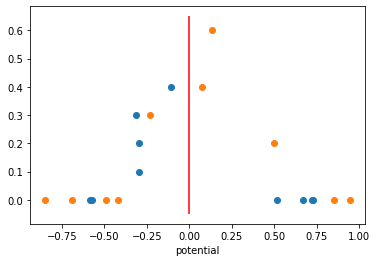

In [ ]:
samples_potentials = [potential(aa.unsqueeze(0)).item()  for aa in samples]
prior_potentials = [potential(aa.unsqueeze(0)).item()  for aa in prior_samples]
print("potentials: ", list(map(lambda p: round(p,3), samples_potentials)))
plt.scatter(samples[:,0], samples_potentials)
plt.scatter(prior_samples[:,0], prior_potentials)
plt.xlabel('first element of samples')
plt.xlabel('potential')
plt.vlines(0.0, ymin=-0.05, ymax=max(samples_potentials+prior_potentials)+0.05, color='r')
plt.show()